last updated 06 11 24

This notebook is to get the run times for each model on the highets and lowest Resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# going upto 150 E because we are saving model every 25 epochs anyway

In [3]:
# imports
import torch

import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torchvision.models import vgg16
from torch.utils.data import DataLoader
#from torch.Utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import numpy as np
import cv2


from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
import time
import random
import cv2

import csv
import json
import pickle
import os

import wandb

import sys
sys.path.append('../.')
from functions import import_imagedata, ImageProcessor, label_oh_tf, IDSWDataSetLoader2
from fns4wandb import set_lossfn
from architectures import sevennet, smallnet1, smallnet2, smallnet3
from architectures import PrintLayer, smallnet3
from loop_fns import loop#, loop_batch, test_loop_batch
from plotting import learning_curve, accuracy_curve, plot_confusion

import copy

#import torch.Utils.data.DataLoader as DataLoader

In [4]:
#p = torch.cuda.memory_summary(device, abbreviated=False)
#Pp = pprint.PrettyPrinter(indent=4)
#Pp.pprint(p)

In [5]:
# file paths
# file paths
optimmy = 'Adam'
model_type = 'vgg16'

_save_location = f'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/NoSched/' 
checkpoint_saveloc = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/modelCheckPoints/"

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = '682f9e66a8c166dc9c1b3de71e8e9f2c72d35ed2'


start_epoch = 0
epoch_val =  3# 150

Var_WB_sched = "NoSched"

load_in_model = False
# write in the directory path for the pkl model file to be read in when loading up model
#dir_pkl = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/{Var_WB_sched}/"
# write in the name of the pkl model file to be read in when loading up models
#pkl_name = f"{model_type}_{resolution}_2024-11-19_{optimmy}_{epoch_val}E_{Var_WB_sched}_{resolution}_0.001_0_{seed}_CrossEntropy.pkl"

In [6]:
wandb.login()


wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [7]:
#!pip install datetime

d = date.today()
#print(str(d), type(str(d)))

452 144 5/452 *100 = 1%
226 72 5/226 *100 = 2%
113 36 5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57 18 (56.5,) 5/57 *100 = 8% -- 2/57 *100 = 3.5% ~ 4%. 1/57 = 1.75%
29 9 (28.5,) 5/29 *100 = 17% -- 2/29 *100 = 6.89 ~ 7% 1/28 = 3.57 ~ 4%
15 5 (14.5, 4.5)
8 3 (7.5,2.5)
4, 2 (, 1.5)

In [8]:
# dictionaries                                                                                  * * * *   SETTINGS   * * * *

date = date.today()

model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[200704,#200704,     #129024,#4096,  # (1x229376 and 25088x4096)  1x229376 and 25088x4096) 1x229376 and 25088x4096)
                             200704,      #(16x64512 and 129024x4096)    (16x200704 and 64512x4096)
                             14336,
                             3584,
                             768,
                             4096,
                             4096,
                            ],
                 'idx': 0,
                 'dropout':0.2}


model_card_7c3l = {'name': '7c3l', 'model': '7c3l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[248832,    # 452 144 # p5
                            59904,      # 226 72 # p5
                            11264,      # 113 36 # p2
                            1536,       # 57 18 # p1
                            172032,           # 29 9
                            172032,          # 15 5
                            172032,         # 8 3
                              ], 
                   'idx': 1,
                  'dropout':0.2}



model_card_4c3l = {'name': '4c3l', 'model': '4c3l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[539904,# 1055232,#539904,    # 452 144 # p5  (64x539904 and 1055232x100)
                             141056, #141056,    # 226 72 # p5   64x141056 and 267264x100)
                             35840,     # 113 36 # p2   (64x35840 and 304640x100)
                             9984,      # 57 18 # p1 
                             2304,      # 29 9
                             512,       # 15 5
                             256],      # 8 3
                  'idx': 2,
                  'dropout':0.2}      

model_card_3c2l = {'name': '3c2l', 'model': '3c2l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[1069888,    # 452 144 # p5
                             274688,     #226 72 # p5
                             68096,      # 113 36 # p2
                             17280,      # 57 18 # p1
                             3840,       # 29 9
                             960,        # 15 5
                             256],
                  'idx': 3,
                  'dropout':0.2}       # 8 3

model_card_2c2l = {'name': '2c2l', 'model': '2c2l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[1055232 , #1032192,# 16883712,#33767424,    # 452 144 # p5 # (1x33767424 and 1055232x100) (1x5276160 and 15828480x100) 1x33767424 and 5276160x100)
                             267264,     #226 72 # p5                   (1x1032192 and 64512x100)
                             64512,#   1032192,#64512,      # 113 36 # p2    ### (16x1055232 and 1032192x100) ###  16x1055232 and 1032192x100)
                             15552,      # 57 18 # p1
                             3072,       # 29 9
                             640,        # 15 5
                             128],
                  'idx': 4,
                  'dropout':0.1}       # 8 3

resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [resolution_card_452144,resolution_card_22672,resolution_card_11336,resolution_card_5715,resolution_card_299,resolution_card_155,resolution_card_83]#[resolution_card_11336, resolution_card_5715,
#resolution_card_299, resolution_card_155, resolution_card_83]#]#resolution_card_452144, 
#resolution_cards = [resolution_card_11336]

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards = [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [1e-3] #[0.1,0.01, 1e-3,1e-4, 1e-5]#, 6e-5, 7e-5, 8e-5]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0]#, 0.1, 0.2]

seeds = [42]#,2,3] # 4, 5,6

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_vgg]

loss_fn_cards = ['CrossEntropy'] #,'CrossEntropy' 'MSE'
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


config.update({'batch_size': 64})
config.update({'start_epoch': start_epoch})
config.update({'epochs': epoch_val}) #60

#print(model_card_vgg)
#print('')
#Pp.pprint(Config) # dictionary of dictionaries of lists and lists of dictionaries

In [9]:
   

Pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
    # flattern nested dictionary
    flatterend_dict = {}
    for k,v in nested_dict.items():
        if isinstance(v, dict):
            for nested_key, nested_val in v.items():
                flatterend_dict[f"{k}_{nested_key}"] = nested_val
        else:
            flatterend_dict[k] =v
    
    columns = list(flatterend_dict.keys())
    
    with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
        # using dictwriter
        writer = csv.DictWriter(f, fieldnames=columns)
        # using writeheader function
        if f.tell() == 0:
            writer.writeheader()
        writer.writerow(flatterend_dict)
        f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        #model_vgg16 = vgg16(weights="IMAGENET1K_V1")
        #vgg_feats = model_vgg16.features
        #vgg_classifier = model_vgg16.classifier
        #vgg_classifier.pop(6)

        #vgg = nn.Sequential(
        #    vgg_feats,
        #    Flattern(),
        #    vgg_classifier,
        #    nn.Linear(4096,11), # cheanging the output layer
        #    nn.Softmax(dim=0),    (1x1032192 and 4096x4096)
        #    )
        #self.flatten = nn.Flatten()
        model_vgg16 = vgg16()
        vgg_feats = model_vgg16.features
        vgg_classifier = model_vgg16.classifier
        vgg_classifier.pop(6)

        vgg = nn.Sequential(
            vgg_feats,
            nn.Flatten(),
            vgg_classifier,
            nn.Linear(4096,11), # cheanging the output layer
            nn.Softmax(dim=0),  
            )
        
        return vgg
       
    else:
        print('Model Name Not Recognised')




def check_model_sizes_bits(model):
    bits = 32
    mods = list(model.modules())
    sizes = []
    total_bits = 0
    
    for i in range(1,len(mods)):
        m = mods[i]
        p = list(m.parameters())
        for j in range(len(p)):
            sizes.append(np.array(p[j].size()))
    
    for i in range(len(sizes)):
        s = sizes[i]
        bitz = np.prod(np.array(s))*bits
        total_bits += bitz
    total_bytes = total_bits/8
    total_megabytes = total_bytes/1e+6
    total_gigabytes = total_megabytes/1000
    print(total_bits, 'bits    ', total_bytes, "bytes    ", total_megabytes, "MegaBytes    ", total_gigabytes,"GigaBytes") # 148480


def ptrblk_fin_mod_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_gb = size_all_mb/953.674
    print('model size: {:.3f}MB'.format(size_all_mb))
    print('model size: {:.3f}GB'.format(size_all_gb))




In [10]:

def train_val_batch(model, train, val, loop_run_name, save_dict, lr, loss_fn, epochs, batch_size, optimizer, scheduler_value, device): #train_dl, val_dl, 
    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3) 
    model.train()

    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []
    sample = False
    
    
    total_epochs = 0
    for epoch in tqdm(range(save_dict['start_epoch'],epochs)): # this is where I edit the epochs

        if epoch == 1:
            sample = True
            random_value = random.randrange(0,batch_size)
        else:
            random_value = None
            sample = False
        #print(random_value)

        
        print('Training...')
        #!nvidia-smi
        #print(len(train)) #Using a target size 

        
        t_loss, train_prediction, train_targets, t_correct, model, optimizer = loop_batch(model, train, loss_fn, batch_size,sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =optimizer, scheduler= scheduler_value, train =True) #, scheduler =scheduler
        #print('training..  2')
        #!nvidia-smi
        
        t_loss_list.append(t_loss)
        [t_predict_list.append(pred) for pred in  train_prediction] #.argmax()
        wandb.log({'t_loss':t_loss})
    
        train_acc = (t_correct/(len(train)*batch_size)*100) ###
        print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
        
        
            
        print('validating...')
        #!nvidia-smi
        
        v_loss, val_prediction, val_targets, val_correct= loop_batch(model, val, loss_fn, batch_size,sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =None, scheduler= None, train =False)

        v_loss_list.append(v_loss)
        [v_predict_list.append(pred) for pred in  val_prediction] #.argmax()
        wandb.log({'v_loss':v_loss})
        
        val_acc = (val_correct/(len(val)*batch_size)*100)
        v_accuracy_list.append(val_acc)
        print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})
    
        total_epochs += 1

        if epoch %25==0 and epoch !=0 and epoch != int(save_dict['start_epoch']):
            #checkpoint = copy.deepcopy(model)
            checkpoint_id = f"{model_type}_{optimmy}_{Var_WB_sched}_{epoch}E_{save_dict['res']}_seed{save_dict['seed']}"
            torch.save(model.state_dict(), checkpoint_saveloc+checkpoint_id, pickle_module=pickle)
            learning_curve(t_loss_list, v_loss_list, save_location=checkpoint_saveloc,run_name=checkpoint_id)
            accuracy_curve(t_accuracy_list, v_accuracy_list,save_location=checkpoint_saveloc,run_name=checkpoint_id)
            #plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = checkpoint_id,save_location =checkpoint_saveloc)
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(train)
    save_dict['validation_samples'] = len(val)
    
    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = train_targets
    save_dict['v_labels'] = val_targets
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    return model, save_dict

from functions import ImageProcessor

def loop_batch(model, data, loss_fn, batch_size, sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =None, scheduler= None, train =True):	# Train and Val loops. Default is train
    model = model
    total_samples = len(data)
    #if optimizer:
    #    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=)
    if train:
        model.train()
        if optimizer != None:
            print("optimizer present")
        where ='tra'
        #lr_ls = []
    else:
        model.eval()   #  (torch.Size([16, 11])) that is different to the input size (torch.Size([11]))
        where = 'val'
    
    predict_list = []
    total_count = 0
    num_correct = 0
    current_loss = 0
    labels =[]

    
    for i, batch in enumerate(data,0):
        #print('loop batch 1')
        #!nvidia-smi
        
        x_batch, y_batch = batch

        if sample == True:
            IP = ImageProcessor(device) #img, scale:int, save_dict;dict, epoch:int, where:str
            i = IP.view(x_batch[random_value],1, loop_run_name, save_dict, epoch, where)
            # 
            sample= False

        #print("x_batch item check ", x_batch[0].shape)
        #print("y_batch item check ", y_batch[0].shape)
        #print("-----   x batch shape   -----",x_batch.shape) #torch.Size([16, 3, 144, 462])

        #print(x_batch[0].shape) # torch.Size([3, 144, 462])
        #print(y_batch[0].shape) # torch.Size([11])

        #print('loop batch 2')
        #!nvidia-smi
        
        
        
        prediction = model.forward(x_batch)

        #print(prediction.shape)  # torch.Size([11])
        #print(y_batch.shape)     # torch.Size([16, 11])

        #print('loop batch 3')
        #!nvidia-smi
        #print("checking range nums  ", len(y_batch), len(y_batch)-1)
        #print("len x batch ", len(x_batch))
        #print("len prediction ", len(prediction))
        #print("prediction  ", prediction.argmax(), prediction.shape)
        #print("prediction[1]", prediction[1].argmax())
        #print("y batch[1]", y_batch[1].argmax(), y_batch[1].shape)

        loss = loss_fn(prediction, y_batch)
        
        #print('loop batch 4')
        #!nvidia-smi

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #print('loop batch 5')
        #!nvidia-smi
            
        [[predict_list.append(pred.argmax().to('cpu')) for pred in preds] for preds in prediction]#.argmax())
        [[labels.append(y.argmax().to('cpu')) for y in ys] for ys in y_batch]
        
        
        for i in range(len(y_batch)-1):
            
            #print("y ",y_batch[i].argmax())
            #print("pred ", prediction[i].argmax())
            if y_batch[i].argmax() == prediction[i].argmax():
                num_correct +=1

        """
        if y_batch[i].argmax() == prediction[i].argmax():
        IndexError: index 11 is out of bounds for dimension 0 with size 11
        """

        total_count+= batch_size
        current_loss += loss.item()

        #print('loop batch 6')
        #!nvidia-smi
        
    if scheduler and scheduler >0:
        scheduler.step()

    if train:
        return current_loss, predict_list, y_batch, num_correct, model, optimizer #, lr_ls
    else:
        return current_loss, predict_list, y_batch, num_correct


def test_loop(model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum, num_classes=11):
    model = model.eval()
    predict_list = []
    current_loss = 0
    total_count =0
    num_correct = 0
    correct = 0
    colour ='colour'
    size =  res

    with torch.no_grad():
        print('Testing...') 
        for idx, img in enumerate(X):

            #image pre processing
            prepro = ImageProcessor(device)
            if model_name == 'vgg16':
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True) #[29, 9], 15, 5, [8,3]
            elif (model_name == '7c3l' and size == [29, 9]) or (model_name == '7c3l' and size == [15, 5]) or (model_name == '7c3l' and size ==[8, 3]):
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True)
            else:
                tense = prepro.colour_size_tense(img, colour, size,av_lum,  pad)


            tense = tense.unsqueeze(dim=0)

            prediction = model.forward(tense)
            label = label_oh_tf(Y[idx], num_classes).to(device)

            label = label.unsqueeze(dim=0)

            loss = loss_fn(prediction, label)

            if prediction.argmax()==label.argmax():
                num_correct +=1
            total_count +=1
            correct +=(prediction.argmax()==label.argmax()).sum().item()

            predict_list.append(prediction.argmax())

        acc = num_correct/total_count
        accuracy = 100*(acc)
        
        
        
        current_loss += loss.item()
        
    return accuracy, predict_list, Y, current_loss

## model, data, loss_fn, device, optimizer =None, scheduler= None, train =True
def test_loop_batch(model,data, loss_fn, batch_size, device):
    model = model.eval()
    predict_list = []
    label_list = []
    total_count =0
    num_correct = 0
    correct = 0
    

    with torch.no_grad():
        for i, batch in enumerate(data,0):
            #tense = tense.to(device)
            tense, label = batch
            label = label.to(device)
            
            prediction = model.forward(tense.to(device))
            #print('p', prediction.shape, 'l ', label.shape)
            #label = label_oh_tf(Y[idx], device, num_classes)
            for i in range(len(label)-1):
                #print(len(label), label[0].argmax(), len(label)-1)
                if label[i].argmax() == prediction[i].argmax():
                    num_correct +=1
            [predict_list.append(pred.argmax()) for pred in prediction]
            [label_list.append(lab.argmax()) for lab in label]
            # label[i] == predictoin[i]. 
    
            #if prediction.argmax()==label.argmax():
            #    num_correct +=1
            total_count += batch_size
            #correct +=(prediction.argmax()==label.argmax()).sum().item()
    
        acc = num_correct/total_count
        accuracy = 100*(acc)

        print(accuracy)

        #print(len(predict_list), len(label_list))
    
        #X = list(X)
        #log_test_score(acc, accuracy, X) # test_acc,test_predict_list, y_test, test_loss 
        return accuracy, predict_list, label_list



def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [11]:
#for model_card in model_cards:
#    lin = get_lin_lay(model_card,[226,72])
#    print(lin)

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"


def _go(config=None):
    #print('1')
    #!nvidia-smi
    
    #print("Max allocated memory (GB):", torch.cuda.max_memory_allocated() / 1024 ** 3)
    
    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        #print('Git Hash registered')
        pass
        
    with wandb.init(config=config, project=f"{model_type}. {epoch_val}E. {Var_WB_sched}. {optimmy}", notes=f"{model_type}. {epoch_val}E. {Var_WB_sched}. {optimmy}",):
        config = wandb.config
        start = time.process_time()
            
        for model_idx, model_card in enumerate(config['model_cards']):
            #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                    
            model_name = model_card['model']
            model_index = model_card['idx']
            dropout = model_card['dropout'] 
            for res_idx, resolution_card in enumerate(config['resolution_cards']):
                #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            
                resolution = resolution_card['resolution']
                pad = resolution_card['padding']
                lin_lay = get_lin_lay(model_card, resolution)
                print('lin lay', lin_lay)
            
                for lr_idx, lr in enumerate(config['learning_rate_cards']):
                    for wd_idx, wd_card in enumerate(wd_cards):
                        for sched_idx, scheduler_value in enumerate(config['scheduler_cards']):
                            
                            for seed_idx, seed in enumerate(config['seeds']):
                                seed = seed
                                for lossfn_idx, loss in enumerate(config['loss_fn_cards']):
                                    
                                    #torch.cuda.empty_cache()
                                    #print('2')
                                    #!nvidia-smi
  
                                    config['batch_size']

                                    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    print('resolution: ', str(resolution), f" idx: {res_idx} / {len(config['resolution_cards'])}")
                                    print('learning rate: ', str(lr), f" idx: {lr_idx} / {len(config['learning_rate_cards'])}")
                                    print('weight decay: ', str(wd_card), f" idx: {wd_idx} / {len(config['wd_cards'])}")
                                    print('scheduler: ', str(scheduler_value), f" idx: {sched_idx} / {len(config['scheduler_cards'])}")
                                    print('seed: ', str(seed), f" idx: {seed_idx} / {len(config['seeds'])}")
                                    print('loss function: ', str(loss), f" idx: {lossfn_idx} / {len(config['loss_fn_cards'])}")
                                    print('Batch size: ', config['batch_size'])
                                    print('Training epochs: ', config['epochs'])
                                    run_start_time = time.process_time()
                                    print('start time: ',run_start_time)
   
                                    print(time.process_time() - start)

                                    epochs = config['epochs'] #40

                                    IP = ImageProcessor(device)

                                    wandb.log({'gitHash':gitHASH})
                                    wandb.log({'Epochs': epochs})
                                    
                                    #print('3')
                                    #!nvidia-smi
                                    
                                    # set save dictionary
                                    save_dict = {'Run' : f"{model_name}_{resolution}_{date}_{optimmy}_{config['epochs']}E_{Var_WB_sched}",
                                                 'Current_Epoch': config['start_epoch'], # this is where i add the start epoch
                                                 'start_epoch':config['start_epoch'],
                                                 'save_location' : _save_location,
                                                 'res': resolution,
                                                 'sched': Var_WB_sched,
                                                 'model': model_name,
                                                 'seed':seed}
          
                                    model = choose_model(model_name, lin_lay, dropout).to(device)
                                    # This is where I want to add the new code
                                    
                                    #model_pkl = torch.load(dir_pkl+pkl_name)
                                    if load_in_model:
                                        with open(dir_pkl+pkl_name, 'rb') as f:
                                            model_pkl = pickle.load(f)
                                        #model_pkl = pickle.load(dir_pkl+pkl_name)
                                        model.load_state_dict(model_pkl['model.state_dict'])

                                    

                                    #print("After model init, Before data loading - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

                                    x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                                    av_lum = IP.new_luminance(x_train)
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
                                    train_ds = IDSWDataSetLoader2(x_train, y_train, resolution,pad,av_lum,model_name, device)# av_lum, res,pad,
                                    train = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2

                                    
                                    test_ds = IDSWDataSetLoader2(x_test, y_test, resolution,pad,av_lum,model_name, device)
                                    test = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    val_ds = IDSWDataSetLoader2(x_val, y_val, resolution,pad,av_lum,model_name, device)
                                    val = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
                                    
                                    print("After data loading - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)


                                    #print('5')
                                    #!nvidia-smi

                                    loss_fn = set_lossfn(loss)
                                    
                                    # set optimizer
                                    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)#torch.optim.Adam(model.parameters(),lr=lr)

                                    wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)
                                    #print('6')
                                    #!nvidia-smi
                                    loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{scheduler_value}_{seed}_{loss}"
         
                                    model, save_dict=  train_val_batch(model, train,val, loop_run_name,save_dict, lr, loss_fn,epochs, config['batch_size'], optimizer, scheduler_value, device)

                                    test_acc,test_predict_list, y_test = test_loop_batch(model,test, loss_fn, config['batch_size'], device) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                                    
                                    #print(test_predict_list)
                                    print(' \n train Acc: ', save_dict['t_accuracy_list'][-1])
                                    print(' \n val Acc: ', save_dict['v_accuracy_list'][-1])
                                    print(' \n test Acc: ', test_acc)
                                    
                                    save_dict.update({'test_acc': test_acc})
                                    save_dict.update({'test_predict': test_predict_list})
                                    save_dict.update({'test_labels': list(y_test)})
                                    #save_dict.update({'test_loss':test_loss})

                                    


                                    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
                                    accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
                                    test_predict_list=[pred.cpu() for pred in test_predict_list]
                                    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
                                    
                                    wandb.log({'test_acc': test_acc})
                                    wandb.log({'test_predict': test_predict_list})
                                    wandb.log({'test_labels': list(y_test)})
                                    #saving
                                    diction = {}
                                    d = date.today()
                                    d=str(d)
                                    diction.update({'Date':d})
                                    diction.update({'gitHASH':str(gitHASH)})
                                    diction.update({'model_name': str(model_name)})
                                    diction.update({'loss_fn': str(loss)})
                                    diction.update({'lr': str(lr)})
                                    diction.update({'wd': str(wd_card)})
                                    diction.update({'scheduler value': str(scheduler_value)})
                                    diction.update({'seed': str(seed)})
                                    diction.update({'resolution': str(resolution)})
                                    diction.update({'pad': int(pad)})
                                    diction.update({'lin_lay': int(lin_lay)})
                                    diction.update({'run time': (time.process_time() - run_start_time)})
                                    diction.update(save_dict)
                                    
                                    save_location = save_dict['save_location']
                                    title = save_dict['Run']
                                    save2json(diction, loop_run_name, save_location)
                                    save2csv(diction, title, save_location)
        
                                    diction['model.state_dict'] = model.state_dict() #to('cpu').
        
                                    with open(f"{save_location}{loop_run_name}.pkl", 'wb+') as f:
                                        #pickle.dump(diction, f)
                                        torch.save(diction, f)
                                    
                                    clear_output()
                                    
                                    print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)
                                    #!nvidia-smi
                                    torch.cuda.empty_cache()
        print('Final Run time: ',time.process_time() - start)

lin lay 200704
Model:  vgg16  idx: 0 / 1
resolution:  [452, 144]  idx: 0 / 7
learning rate:  0.001  idx: 0 / 1
weight decay:  0  idx: 0 / 1
scheduler:  0  idx: 0 / 1
seed:  42  idx: 0 / 1
loss function:  CrossEntropy  idx: 0 / 1
Batch size:  64
Training epochs:  3
start time:  12.65446387
0.001044304000000551
/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/
After data loading - Current allocated memory (GB): 0.501183032989502


  0%|   | 0/3 [00:00<?, ?it/s]

Training...
optimizer present
train accuracy:  8.834134615384617
validating...


 33%|▎| 1/3 [00:08<00:17,  8.5

validation accuracy:  10.795454545454545
Training...
optimizer present


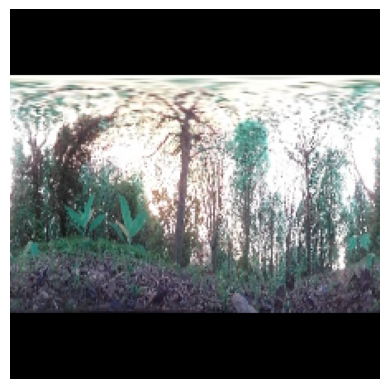

train accuracy:  8.11298076923077
validating...


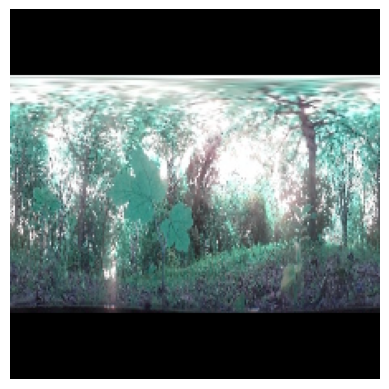

 67%|▋| 2/3 [00:16<00:08,  8.4

validation accuracy:  11.363636363636363
Training...
optimizer present
train accuracy:  9.254807692307693
validating...


100%|█| 3/3 [00:25<00:00,  8.4

validation accuracy:  11.931818181818182


11.81640625
 
 train Acc:  9.254807692307693
 
 val Acc:  11.931818181818182
 
 test Acc:  11.81640625


Traceback (most recent call last):
  File "/tmp/ipykernel_132227/2121896068.py", line 144, in _go
    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
  File "/its/home/nn268/antvis/antvis/optics/Batchcode/.././plotting.py", line 87, in learning_curve
    plt.savefig(save_location+'/'+lab+'.png') #run_name
  File "/its/home/nn268/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 1119, in savefig
    res = fig.savefig(*args, **kwargs)  # type: ignore[func-returns-value]
  File "/its/home/nn268/.local/lib/python3.10/site-packages/matplotlib/figure.py", line 3390, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/its/home/nn268/.local/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 2193, in print_figure
    result = print_method(
  File "/its/home/nn268/.local/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 2043, in <lambda>
    print_method = fu

Epochs,▁
t_loss,▃█▁
train_acc,▅▁█
v_loss,█▄▁
val_acc,▁▄█
Epochs,3
gitHash,682f9e66a8c166dc9c1b...
t_loss,62.34517
train_acc,9.25481
v_loss,26.37677
val_acc,11.93182


FileNotFoundError: [Errno 2] No such file or directory: '/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/vgg16/Adam/NoSched//Learning Curve vgg16_[452, 144]_2025-01-09_Adam_3E_NoSched_[452, 144]_0.001_0_42_CrossEntropy.png'

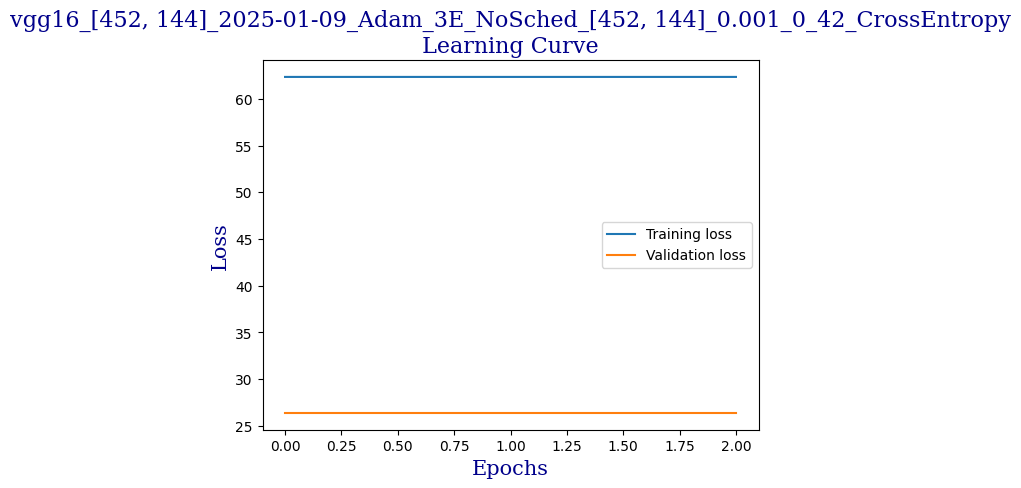

In [13]:
_go(config)

In [ ]:
# 12.58 GiB. GPU 0 has a total capacty of 23.65 GiB of which 8.04 GiB is free
23.65-8.04


pred torch.Size([11])

lab  torch.Size([5, 11])

# 

18/11/24
Added in the checkpoints every 25 epochs
Checked that optimizer = SGD and not optimizer =optimizer = SGD
set total epochs to 150.
added in the creation and saving of LC and AC at each checkpoint.
so checkpoints have a save of the model state dicts and lc and ac so far.

HOWEVER
there still does not look to be any learning... lc are flat and do not change over epochs.
in the pytroch sgd page, the examples use momentum (0.9)
considering running again with  momentum.

hmm. no. 


THIS FILE HAS CUDA OUT OF MEMORY ISSUE
bigloop_vgg16_BATCHING_300E_SGD_copyFromPrevVGGVersion  SEEMS TO BE WORKING FINE. i CHANGED WHERE OPTIMIZER.ZERO_GRAD GOES, AFTER WEIGHTS UPDATE, SEEMS TO HELP